In [ ]:
import base64
import json
import pickle
import mwapi
from tqdm import tqdm
import pandas as pd
import ipinfo
import ipaddress
import numpy as np
from collections import defaultdict
import geopandas as gpd
import requests
from ipaddress import ip_address, IPv4Address
import socket, struct
import math
from binascii import hexlify
import mysql.connector

In [ ]:
def decode_json(path):
    processed_dict = {}

    with open(path) as f:
        for line in f:
            observation = json.loads(line)
            if 'cache' in observation:
                observation['cache'] = pickle.loads(
                    base64.b85decode(bytes(observation['cache'], 'ascii')))
            else:
                continue

            processed_dict[observation['rev_id']] = {
                'damaging': observation['damaging'],
                'goodfaith': observation['goodfaith']
            }
            processed_dict[observation['rev_id']].update(observation['cache'])
            
    return processed_dict

In [ ]:
def validIPAddress(IP):
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

def ip2long(ip, kind):
    """
    Convert an IP string to long
    """
    if kind == "IPv4":
        packedIP = socket.inet_aton(ip)
        return struct.unpack("!L", packedIP)[0]
    else:
        return int(hexlify(socket.inet_pton(socket.AF_INET6, ip)), 16)

In [ ]:
def get_metadata(processed_dict):
    session = mwapi.Session('https://en.wikipedia.org')

    # ip --> country enabled for ipv4 for this using ip2location free database: https://download.ip2location.com/lite/
    cnx = mysql.connector.connect(user='',
                                  password='',
                                  host='127.0.0.1',
                                  database='ip2location')

    query_ipv4 = ("SELECT country_code FROM ip2location_db1 "
             "WHERE ip_from < %s AND ip_to > %s")
    
    query_ipv6 = ("SELECT country_code FROM ip2location_db1_ipv6 "
             "WHERE ip_from < %s AND ip_to > %s")

    for rev_id in tqdm(processed_dict.keys()):

        s = session.get(action='query', prop='revisions', revids=rev_id, rvprop='ids|timestamp|flags|comment|user|tags')
        for rev in s['query']['pages'].values():
            processed_dict[rev_id]['title'] = rev['title']
            processed_dict[rev_id]['user'] = rev['revisions'][0]['user']
            processed_dict[rev_id]['timestamp'] = rev['revisions'][0]['timestamp']
            processed_dict[rev_id]['comment'] = rev['revisions'][0]['comment']

            if 'anon' in rev['revisions'][0]:
                processed_dict[rev_id]['anon'] = True
            else:
                processed_dict[rev_id]['anon'] = False

            if 'minor' in rev['revisions'][0]:
                processed_dict[rev_id]['minor'] = True
            else:
                processed_dict[rev_id]['minor'] = False

            if processed_dict[rev_id]['anon']:
                try:
                    cursor = cnx.cursor()
                    ip_kind = validIPAddress(rev['revisions'][0]['user'])
                    ip = ip2long(rev['revisions'][0]['user'], ip_kind)
                    
                    if ip_kind == "IPv4":
                        cursor.execute(query_ipv4, (ip, ip))
                    elif ip_kind == "IPv6":
                        cursor.execute(query_ipv6, (ip, ip))

                    for country in cursor:
                        processed_dict[rev_id]['country'] = country

                    cursor.close()
                except:
                    processed_dict[rev_id]['country'] = None
            else:
                processed_dict[rev_id]['country'] = None

            if "bot" in rev['revisions'][0]['user'].lower():
                processed_dict[rev_id]['possible_bot'] = True
            else:
                processed_dict[rev_id]['possible_bot'] = False

            processed_dict[rev_id]['tags'] = rev['revisions'][0]['tags']

    cnx.close()
    return processed_dict

# Dataset analysis

In [ ]:
processed_dict = decode_json("/Users/haltriedman/Downloads/enwiki.labeled_revisions.20k_2015.goodfaith_extracted.json")
processed_dict = get_metadata(processed_dict)

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame.from_dict(processed_dict, orient='index')

In [ ]:
pd.options.display.max_columns = None

In [ ]:
df['seconds_since_registration'] = np.exp(df['feature.log((temporal.revision.user.seconds_since_registration + 1))']) - 1
df['days_since_registration'] = df['seconds_since_registration'] / 86400
df['years_since_registration'] = df['days_since_registration'] / 365

In [ ]:
keep = ['damaging', 'goodfaith', 'feature.revision.page.is_articleish',
        'feature.revision.page.is_mainspace', 'feature.revision.page.is_draftspace',
        'feature.revision.diff.chars_change', 'feature.revision.diff.tokens_change',
        'feature.revision.diff.words_change', 'seconds_since_registration',
        'days_since_registration', 'years_since_registration',
        'feature.english.badwords.revision.diff.match_delta_sum',
        'feature.english.informals.revision.diff.match_delta_sum',
        'feature.english.dictionary.revision.diff.dict_word_delta_sum',
        'feature.english.dictionary.revision.diff.non_dict_word_delta_sum',
        'user', 'feature.revision.user.is_bot', 'feature.revision.user.has_advanced_rights',
        'feature.revision.user.is_anon', 'country', 'tags', 'timestamp']
filtered = df[keep]
filtered.timestamp = pd.to_datetime(filtered.timestamp)

/Users/haltriedman/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
filtered

damaging  goodfaith  feature.revision.page.is_articleish  \
644933637     False       True                                False   
629393521     False       True                                 True   
655365754     False       True                                False   
616502017     False       True                                 True   
651762922     False       True                                False   
...             ...        ...                                  ...   
638824482     False       True                                 True   
644863569      True      False                                 True   
620976195     False       True                                 True   
647130958     False       True                                 True   
654745956     False       True                                 True   

           feature.revision.page.is_mainspace  \
644933637                               False   
629393521                                True   
655365754                               False   
616502017                                True   
651762922                               False   
...                                       ...   
638824482                                True   
644863569                                True   
620976195                                True   
647130958                                True   
654745956                                True   

           feature.revision.page.is_draftspace  \
644933637                                False   
629393521                                False   
655365754                                False   
616502017                                False   
651762922                                False   
...                                        ...   
638824482                                False   
644863569                                False   
620976195                                False   
647130958                                False   
654745956                                False   

           feature.revision.diff.chars_change  \
644933637                              1758.0   
629393521                                 1.0   
655365754                                99.0   
616502017                                11.0   
651762922                               662.0   
...                                       ...   
638824482                                -4.0   
644863569                                 1.0   
620976195                                90.0   
647130958                                26.0   
654745956                               194.0   

           feature.revision.diff.tokens_change  \
644933637                                312.0   
629393521                                  1.0   
655365754                                 99.0   
616502017                                  2.0   
651762922                                149.0   
...                                        ...   
638824482                                 -1.0   
644863569                                  0.0   
620976195                                  3.0   
647130958                                  8.0   
654745956                                 68.0   

           feature.revision.diff.words_change  seconds_since_registration  \
644933637                                78.0                 252046960.0   
629393521                                 0.0                  16107886.0   
655365754                                 0.0                 301898190.0   
616502017                                 1.0                         0.0   
651762922                                51.0                 119055508.0   
...                                       ...                         ...   
638824482                                 0.0                         0.0   
644863569                                 2.0                       108.0   
620976195                                 0.0                  31073023.0   
64713095

In [ ]:
not_damaging, damaging = filtered['damaging'].value_counts().sort_index().tolist()
not_goodfaith, goodfaith = filtered['goodfaith'].value_counts().sort_index().tolist()

In [ ]:
damaging, not_damaging

(745, 18519)

In [ ]:
goodfaith, not_goodfaith

(18758, 506)

In [ ]:
# filtered.to_csv('/Users/haltriedman/Downloads/enwiki_editquality_filtered.csv') # save as checkpoint

filtered = pd.read_csv('/Users/haltriedman/Downloads/enwiki_editquality_filtered.csv', index_col=0) # load from checkpoint
filtered['tags'] = filtered.tags.apply(lambda x: x[1:-1].replace("'", "").split(',') if x[1:-1].replace("'", "").split(',')[0] != "" else [])
filtered['country'] = filtered.country.apply(lambda x: x[2:4] if isinstance(x, str) else None)
filtered['timestamp'] = pd.to_datetime(filtered.timestamp)

In [ ]:
count = 0
tag_dict = defaultdict(int)

for _, i in filtered[filtered['tags'].map(len) > 0]['tags'].items():
    add_to_count = False
    for j in i:
        tag_dict[j.lower()] += 1
        if 'mobile' in j:
            add_to_count = True
    
    if add_to_count:
        count += 1

In [ ]:
print(count)
pd.DataFrame.from_dict({k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}, columns=['frequency'], orient='index')

497


frequency
mobile edit                         496
 mobile web edit                    340
 mobile app edit                    103
visualeditor                         71
gettingstarted edit                  51
mw-add-media                         40
 mw-remove-media                     34
section blanking                     24
possible libel or vandalism          20
 canned edit summary                 11
possible vandalism                   11
 possible libel or vandalism          8
extraneous markup                     8
wikilove                              7
 visualeditor                         5
blanking                              5
changing height or weight             4
categories removed                    4
repeating characters                  3
very short new article                2
adding email address                  2
 repeating characters                 2
coi-spam                              2
 changing height or weight            2
 nowiki added                         2
nowiki added                          2
 reference list removal               1
 categories removed                   1
 gettingstarted edit                  1
mobile app edit                       1
shouting                              1
 possible vandalism                   1
 bad external                         1
visualeditor-switched                 1
reverting anti-vandal bot             1
bad external                          1
 blanking                             1
reference list removal                1
talk page blanking                    1

In [ ]:
print(filtered.loc[(filtered['feature.revision.user.is_anon'] == True)].shape)

(0, 22)
(3467, 22)


2014-04-15 00:17:00+00:00
2015-04-14 23:33:48+00:00


Text(0.5, 1.0, 'Histogram of revisions by month')

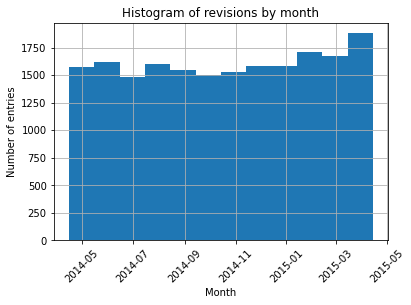

In [ ]:
print(filtered['timestamp'].min())
print(filtered['timestamp'].max())

ax = filtered['timestamp'].hist(bins=12, xrot=45)
ax.set_xlabel("Month")
ax.set_ylabel("Number of entries")
ax.set_title("Histogram of revisions by month")

In [ ]:
inter = pd.DataFrame(pd.cut(filtered['timestamp'], bins=12))
inter['count'] = 1
inter.groupby("timestamp").count()

count
timestamp                                               
(2014-04-14 15:31:26.592000, 2014-05-15 10:13:24]   1569
(2014-05-15 10:13:24, 2014-06-14 20:09:48]          1621
(2014-06-14 20:09:48, 2014-07-15 06:06:12]          1481
(2014-07-15 06:06:12, 2014-08-14 16:02:36]          1604
(2014-08-14 16:02:36, 2014-09-14 01:59:00]          1542
(2014-09-14 01:59:00, 2014-10-14 11:55:24]          1501
(2014-10-14 11:55:24, 2014-11-13 21:51:48]          1528
(2014-11-13 21:51:48, 2014-12-14 07:48:12]          1578
(2014-12-14 07:48:12, 2015-01-13 17:44:36]          1578
(2015-01-13 17:44:36, 2015-02-13 03:41:00]          1707
(2015-02-13 03:41:00, 2015-03-15 13:37:24]          1675
(2015-03-15 13:37:24, 2015-04-14 23:33:48]          1880

Time since registration

0.0
13.566317541856945


Text(0.5, 1.0, 'Histogram of years since registration')

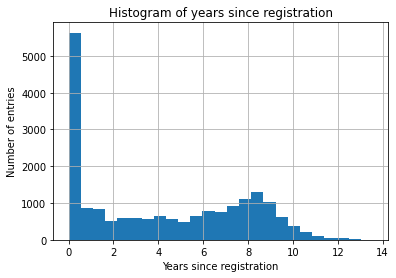

In [ ]:
print(filtered['years_since_registration'].min())
print(filtered['years_since_registration'].max())

ax = filtered['years_since_registration'].hist(bins=25)
ax.set_xlabel("Years since registration")
ax.set_ylabel("Number of entries")
ax.set_title("Histogram of years since registration")

In [ ]:
inter = pd.DataFrame(pd.cut(filtered['years_since_registration'], [0, 3, 6, 9, 12, 15]))
inter['count'] = 1
# inter
inter.groupby('years_since_registration').count()

count
years_since_registration       
(0, 3]                     5303
(3, 6]                     3207
(6, 9]                     5473
(9, 12]                    1753
(12, 15]                     61

In [ ]:
filtered.describe()[
    ['feature.revision.diff.chars_change',
     'feature.revision.diff.tokens_change',
     'feature.revision.diff.words_change',
     'feature.english.badwords.revision.diff.match_delta_sum',
     'feature.english.informals.revision.diff.match_delta_sum',
     'feature.english.dictionary.revision.diff.dict_word_delta_sum',
     'feature.english.dictionary.revision.diff.non_dict_word_delta_sum'
    ]
]

feature.revision.diff.chars_change  \
count                        19264.000000   
mean                           182.857039   
std                           4175.845471   
min                        -143052.000000   
25%                             -1.000000   
50%                             17.000000   
75%                            137.000000   
max                         380779.000000   

       feature.revision.diff.tokens_change  \
count                         19264.000000   
mean                             67.893376   
std                            1708.397069   
min                          -54267.000000   
25%                               0.000000   
50%                               6.000000   
75%                              45.000000   
max                          171188.000000   

       feature.revision.diff.words_change  \
count                        19264.000000   
mean                            23.710496   
std                            451.176295   
min                         -15420.000000   
25%                              0.000000   
50%                              2.000000   
75%                             15.000000   
max                          39578.000000   

       feature.english.badwords.revision.diff.match_delta_sum  \
count                                       19264.000000        
mean                                            0.003997        
std                                             0.441847        
min                                           -12.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                            27.000000        

       feature.english.informals.revision.diff.match_delta_sum  \
count                                       19264.000000         
mean                                            0.666269         
std                                             5.668833         
min                                          -414.000000         
25%                                             0.000000         
50%                                             0.000000         
75%                                             0.000000         
max                                           144.000000         

       feature.english.dictionary.revision.diff.dict_word_delta_sum  \
count                                       19264.000000              
mean                                           21.258358              
std                                           369.410789              
min                                        -12778.000000              
25%                                             0.000000              
50%                                             1.000000              
75%                                            13.000000              
max                                         29842.000000              

       feature.english.dictionary.revision.diff.non_dict_word_delta_sum  
count                                       19264.000000                 
mean                                            2.452139                 
std                                            92.957819                 
min                                         -3544.000000                 
25%                                             0.000000                 
50%                                             0.000000                 
75%                                             2.000000                 
max                                          9736.000000

In [ ]:
filtered.loc[filtered['damaging'] == True].describe()[
    ['feature.revision.diff.chars_change',
     'feature.revision.diff.tokens_change',
     'feature.revision.diff.words_change',
     'feature.english.badwords.revision.diff.match_delta_sum',
     'feature.english.informals.revision.diff.match_delta_sum',
     'feature.english.dictionary.revision.diff.dict_word_delta_sum',
     'feature.english.dictionary.revision.diff.non_dict_word_delta_sum'
    ]
]

feature.revision.diff.chars_change  \
count                          745.000000   
mean                          -482.158389   
std                           4651.712861   
min                         -59148.000000   
25%                             -4.000000   
50%                             11.000000   
75%                             50.000000   
max                          47697.000000   

       feature.revision.diff.tokens_change  \
count                           745.000000   
mean                           -156.846980   
std                            1495.210048   
min                          -18197.000000   
25%                              -2.000000   
50%                               3.000000   
75%                              17.000000   
max                           14951.000000   

       feature.revision.diff.words_change  \
count                          745.000000   
mean                           -54.781208   
std                            553.564261   
min                          -6926.000000   
25%                              0.000000   
50%                              1.000000   
75%                              8.000000   
max                           5996.000000   

       feature.english.badwords.revision.diff.match_delta_sum  \
count                                         745.000000        
mean                                            0.005369        
std                                             0.791401        
min                                           -12.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                             6.000000        

       feature.english.informals.revision.diff.match_delta_sum  \
count                                         745.000000         
mean                                            0.034899         
std                                             2.033686         
min                                           -25.000000         
25%                                             0.000000         
50%                                             0.000000         
75%                                             0.000000         
max                                            17.000000         

       feature.english.dictionary.revision.diff.dict_word_delta_sum  \
count                                         745.000000              
mean                                          -50.089933              
std                                           506.680289              
min                                         -6432.000000              
25%                                            -1.000000              
50%                                             1.000000              
75%                                             6.000000              
max                                          5459.000000              

       feature.english.dictionary.revision.diff.non_dict_word_delta_sum  
count                                         745.000000                 
mean                                           -4.691275                 
std                                            51.815209                 
min                                          -762.000000                 
25%                                             0.000000                 
50%                                             0.000000                 
75%                                             1.000000                 
max                                           537.000000

In [ ]:
filtered.loc[filtered['goodfaith'] == True].describe()[
    ['feature.revision.diff.chars_change',
     'feature.revision.diff.tokens_change',
     'feature.revision.diff.words_change',
     'feature.english.badwords.revision.diff.match_delta_sum',
     'feature.english.informals.revision.diff.match_delta_sum',
     'feature.english.dictionary.revision.diff.dict_word_delta_sum',
     'feature.english.dictionary.revision.diff.non_dict_word_delta_sum'
    ]
]

feature.revision.diff.chars_change  \
count                        18758.000000   
mean                           210.484966   
std                           4143.037624   
min                        -143052.000000   
25%                             -1.000000   
50%                             18.000000   
75%                            144.000000   
max                         380779.000000   

       feature.revision.diff.tokens_change  \
count                         18758.000000   
mean                             77.091054   
std                            1708.810427   
min                          -54267.000000   
25%                               0.000000   
50%                               6.000000   
75%                              47.000000   
max                          171188.000000   

       feature.revision.diff.words_change  \
count                        18758.000000   
mean                            27.019032   
std                            445.978991   
min                         -15420.000000   
25%                              0.000000   
50%                              2.000000   
75%                             16.000000   
max                          39578.000000   

       feature.english.badwords.revision.diff.match_delta_sum  \
count                                       18758.000000        
mean                                            0.003998        
std                                             0.419363        
min                                           -12.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                            27.000000        

       feature.english.informals.revision.diff.match_delta_sum  \
count                                       18758.000000         
mean                                            0.685148         
std                                             5.730594         
min                                          -414.000000         
25%                                             0.000000         
50%                                             0.000000         
75%                                             0.000000         
max                                           144.000000         

       feature.english.dictionary.revision.diff.dict_word_delta_sum  \
count                                       18758.000000              
mean                                           24.284998              
std                                           362.874316              
min                                        -12778.000000              
25%                                             0.000000              
50%                                             2.000000              
75%                                            14.000000              
max                                         29842.000000              

       feature.english.dictionary.revision.diff.non_dict_word_delta_sum  
count                                       18758.000000                 
mean                                            2.734033                 
std                                            93.707615                 
min                                         -3544.000000                 
25%                                             0.000000                 
50%                                             0.000000                 
75%                                             2.000000                 
max                                          9736.000000

In [ ]:
filtered.groupby('country').count().sort_values('damaging', ascending=False)['damaging']

country
US    1353
GB     417
IN     195
CA     182
AU     168
      ... 
MM       1
MP       1
GT       1
NI       1
GM       1
Name: damaging, Length: 116, dtype: int64

In [ ]:
countries = pd.DataFrame(filtered.groupby('country').count().sort_values('damaging', ascending=False)['damaging'])
all_countries = pd.read_csv('fips.csv')

countries = all_countries.merge(countries, left_on='ISO 3166', right_on=countries.index, how='left').fillna(0)
countries[['Name', 'ISO 3166', 'damaging']].groupby(['Name', 'ISO 3166']).max().sort_values('damaging', ascending=False)[:24]

damaging
Name                        ISO 3166          
United States               US          1353.0
Isle of Man                 GB           417.0
Guernsey                    GB           417.0
United Kingdom              GB           417.0
Jersey                      GB           417.0
India                       IN           195.0
Canada                      CA           182.0
Coral Sea Islands           AU           168.0
Ashmore and Cartier Islands AU           168.0
Australia                   AU           168.0
Germany                     DE            84.0
Philippines                 PH            69.0
Brazil                      BR            53.0
Italy                       IT            41.0
France                      FR            41.0
Ireland                     IE            38.0
Netherlands                 NL            36.0
Malaysia                    MY            34.0
Pakistan                    PK            33.0
Mexico                      MX            28.0
Spain                       ES            28.0
New Zealand                 NZ            26.0
Russia                      RU            25.0
Poland                      PL            25.0

In [ ]:
shapefile = '/Users/haltriedman/Downloads/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ISO_A2', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

merged = gdf.merge(countries, left_on='country_code', right_on='ISO 3166', how='left')
merged = merged.fillna(0)

#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [ ]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool
from bokeh.palettes import brewer
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)
#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = 'Viridis256', low = 0, high = 1400)
#Define custom tick labels for color bar.
tick_labels = {'0': '0 revisions',
               '200': '200 revisions',
               '400': '400 revisions',
               '600': '600 revisions',
               '800': '800 revisions',
               '1000': '1000 revisions',
               '1200': '1200 revisions',
               '1400': '1400 revisions',
              }

#Add hover tool
hover = HoverTool(tooltips = [ ('Country/region','@country'),('Number of revisions', '@damaging')])

#Create color bar. 
color_bar = ColorBar(
    color_mapper=color_mapper,
    label_standoff=8,
    width = 500, height = 20,
    border_line_color=None,
    location = (0,0),
    orientation = 'horizontal',
    major_label_overrides = tick_labels)
#Create figure object.
p = figure(title = 'Number of revisions in the dataset',
           plot_height = 600 ,
           plot_width = 950,
           toolbar_location = None, 
           tools=[hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'damaging', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify figure layout.
p.add_layout(color_bar, 'below')
#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [ ]:
new_editor_revs = filtered[(filtered['years_since_registration'] < 1) & (filtered['feature.revision.user.is_bot'] == False)]
anon_revs = filtered[(filtered['feature.revision.user.is_anon'] == True) & (filtered['feature.revision.user.is_bot'] == False)]
mobile_revs = filtered[filtered['tags'].apply(lambda x: 'mobile edit' in x or 'mobile web edit' in x or 'mobile app edit' in x)]
non_us_revs = filtered[(filtered['country'] != "US") & (~filtered['country'].isnull())]

In [ ]:
_, all_damaging = filtered['damaging'].value_counts().sort_index().tolist()
_, all_goodfaith = filtered['goodfaith'].value_counts().sort_index().tolist()

In [ ]:
not_damaging, damaging = new_editor_revs['damaging'].value_counts().sort_index().tolist()
not_goodfaith, goodfaith = new_editor_revs['goodfaith'].value_counts().sort_index().tolist()
print(not_damaging, round(not_damaging / new_editor_revs.shape[0], 4), damaging, round(damaging / new_editor_revs.shape[0], 4))
print(not_goodfaith, round(not_goodfaith / new_editor_revs.shape[0], 4), goodfaith, round(goodfaith / new_editor_revs.shape[0], 4))

print(abs(round(damaging / new_editor_revs.shape[0] - all_damaging / filtered.shape[0], 4)))
print(abs(round(goodfaith / new_editor_revs.shape[0] - all_goodfaith / filtered.shape[0], 4)))

5515 0.8874 700 0.1126
478 0.0769 5737 0.9231
0.074
0.0506


In [ ]:
not_damaging, damaging = anon_revs['damaging'].value_counts().sort_index().tolist()
not_goodfaith, goodfaith = anon_revs['goodfaith'].value_counts().sort_index().tolist()
print(not_damaging, round(not_damaging / anon_revs.shape[0], 4), damaging, round(damaging / anon_revs.shape[0], 4))
print(not_goodfaith, round(not_goodfaith / anon_revs.shape[0], 4), goodfaith, round(goodfaith / anon_revs.shape[0], 4))

print(abs(round(damaging / anon_revs.shape[0] - all_damaging / filtered.shape[0], 4)))
print(abs(round(goodfaith / anon_revs.shape[0] - all_goodfaith / filtered.shape[0], 4)))

2990 0.8624 477 0.1376
339 0.0978 3128 0.9022
0.0989
0.0715


In [ ]:
not_damaging, damaging = mobile_revs['damaging'].value_counts().sort_index().tolist()
not_goodfaith, goodfaith = mobile_revs['goodfaith'].value_counts().sort_index().tolist()
print(not_damaging, round(not_damaging / mobile_revs.shape[0], 4), damaging, round(damaging / mobile_revs.shape[0], 4))
print(not_goodfaith, round(not_goodfaith / mobile_revs.shape[0], 4), goodfaith, round(goodfaith / mobile_revs.shape[0], 4))

print(abs(round(damaging / mobile_revs.shape[0] - all_damaging / filtered.shape[0], 4)))
print(abs(round(goodfaith / mobile_revs.shape[0] - all_goodfaith / filtered.shape[0], 4)))

393 0.7907 104 0.2093
73 0.1469 424 0.8531
0.1706
0.1206


In [ ]:
not_damaging, damaging = non_us_revs['damaging'].value_counts().sort_index().tolist()
not_goodfaith, goodfaith = non_us_revs['goodfaith'].value_counts().sort_index().tolist()
print(not_damaging, round(not_damaging / non_us_revs.shape[0], 4), damaging, round(damaging / non_us_revs.shape[0], 4))
print(not_goodfaith, round(not_goodfaith / non_us_revs.shape[0], 4), goodfaith, round(goodfaith / non_us_revs.shape[0], 4))

print(abs(round(damaging / non_us_revs.shape[0] - all_damaging / filtered.shape[0], 4)))
print(abs(round(goodfaith / non_us_revs.shape[0] - all_goodfaith / filtered.shape[0], 4)))

1854 0.877 260 0.123
173 0.0818 1941 0.9182
0.0843
0.0556


# Model Analysis

In [1]:
from revscoring.scoring.models.model import Model
from revscoring.extractors import api

from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'revscoring'

In [ ]:
resp = requests.get("https://labels.wmflabs.org/campaigns/enwiki/41/?tasks")
data = resp.json()

with open('/Users/haltriedman/Downloads/2016_labels.json', 'w') as f:
    for i, label in enumerate(data['tasks']):
        out = {}
    #     print(label)

        # skip if unlabeled
        if len(label['labels']) == 0:
            continue

        # skip if unsure
        if label['labels'][0]['data']['unsure']:
            continue

        # skip if incomplete labels
        if label['labels'][0]['data']['damaging'] is None or label['labels'][0]['data']['goodfaith'] is None:
            continue

        out['rev_id'] = int(label['data']['rev_id'])
        out['auto_labeled'] = False
        out['damaging'] = label['labels'][0]['data']['damaging']
        out['goodfaith'] = label['labels'][0]['data']['goodfaith']
        out['autolabel'] = {}
        out = json.dumps(out) + "\n"
#         print(out)
        f.write(out)

In [ ]:
processed_dict = decode_json("/Users/haltriedman/Downloads/2016_labels.extracted.json")
# processed_dict = get_metadata(processed_dict)

In [ ]:
test_df = pd.DataFrame.from_dict(processed_dict, orient='index')
test_df['seconds_since_registration'] = np.exp(test_df['feature.log((temporal.revision.user.seconds_since_registration + 1))']) - 1
test_df['days_since_registration'] = test_df['seconds_since_registration'] / 86400
test_df['years_since_registration'] = test_df['days_since_registration'] / 365

# test_filtered = test_df[keep]
# test_filtered.timestamp = pd.to_datetime(test_filtered.timestamp)
# test_filtered['country'] = test_filtered.country.apply(lambda x: x[0] if isinstance(x, tuple) else None)

# test_filtered.to_csv('/Users/haltriedman/Downloads/enwiki_editquality_filtered.test.csv') # save as checkpoint

In [ ]:
test_filtered = pd.read_csv('/Users/haltriedman/Downloads/enwiki_editquality_filtered.test.csv', index_col=0) # load from checkpoint
test_filtered['tags'] = test_filtered.tags.apply(lambda x: x[1:-1].replace("'", "").split(',') if x[1:-1].replace("'", "").split(',')[0] != "" else [])
test_filtered['country'] = test_filtered.country.apply(lambda x: x[2:4] if isinstance(x, str) else None)
test_filtered['timestamp'] = pd.to_datetime(test_filtered.timestamp)

In [ ]:
test_filtered[test_filtered.damaging]

damaging  goodfaith  feature.revision.page.is_articleish  \
707034500      True      False                                False   
679493558      True       True                                 True   
703537919      True       True                                 True   
723445357      True      False                                 True   
735059725      True       True                                 True   
...             ...        ...                                  ...   
693341123      True       True                                 True   
711351248      True       True                                 True   
726978946      True       True                                 True   
710969144      True      False                                False   
719486808      True      False                                 True   

           feature.revision.page.is_mainspace  \
707034500                               False   
679493558                                True   
703537919                                True   
723445357                                True   
735059725                                True   
...                                       ...   
693341123                                True   
711351248                                True   
726978946                                True   
710969144                               False   
719486808                                True   

           feature.revision.page.is_draftspace  \
707034500                                False   
679493558                                False   
703537919                                False   
723445357                                False   
735059725                                False   
...                                        ...   
693341123                                False   
711351248                                False   
726978946                                False   
710969144                                False   
719486808                                False   

           feature.revision.diff.chars_change  \
707034500                               519.0   
679493558                               294.0   
703537919                                35.0   
723445357                               -35.0   
735059725                               719.0   
...                                       ...   
693341123                                45.0   
711351248                                 3.0   
726978946                                27.0   
710969144                               282.0   
719486808                                43.0   

           feature.revision.diff.tokens_change  \
707034500                                161.0   
679493558                                 82.0   
703537919                                 11.0   
723445357                                -14.0   
735059725                                252.0   
...                                        ...   
693341123                                 19.0   
711351248                                 -2.0   
726978946                                  4.0   
710969144                                108.0   
719486808                                 14.0   

           feature.revision.diff.words_change  seconds_since_registration  \
707034500                                73.0                 289301018.0   
679493558                                34.0                      8614.0   
703537919                                 6.0                         0.0   
723445357                                -4.0                   7423880.0   
735059725                               108.0                      8631.0   
...                                       ...                         ...   
693341123                                 9.0                         0.0   
711351248                                -1.0                         0.0   
726978946                                 2.0                         0.0   
71096914

In [ ]:
def get_X_y(model, df, label):
    features = ["feature." + f.name for f in model.features]
    X_test = df[features]
    y_test = df[label].map(lambda x: 1 if x is True else 0)
    return X_test, y_test

In [ ]:
def score_model(model, X_test):
    scores = {}

    for x in X_test.iterrows():
        score = model.score(x[1].tolist())
        scores[x[0]] = {}
        scores[x[0]]['prediction'] = score['prediction']
        scores[x[0]]['prob'] = score['probability'][True]
    
    return scores

In [ ]:
def get_outputs(df):
    y_true = df['actual'].to_numpy()
    y_pred = df['prediction'].to_numpy()
    y_prob = df['prob'].to_numpy()
    return y_true, y_pred, y_prob

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

def create_report(model, y_true, y_pred, y_prob):
    data = {}
    
    print("=======================================")
    print("model metadata")
    print("=======================================")
    print(model.info.format())
    print()

    print("=======================================")
    print("classification report")
    print("=======================================")
    print(classification_report(y_true, y_pred))
    print()
    
    cr = classification_report(y_true, y_pred, output_dict=True)
    data["accuracy"] = cr["accuracy"]
    for label in ["0", "1"]:
        for k, v in cr[label].items():
            data[f"{k}_{label}"] = v
    
    print("=======================================")
    print("confusion matrix")
    print("=======================================")
    (tn, fp, fn, tp)  = confusion_matrix(y_true, y_pred).ravel()
    data["true negatives"] = tn
    data["true positives"] = tp
    data["false negatives"] = fn
    data["false positives"] = fp
    print("true negatives: ", tn)
    print("false negatives: ", fn)
    print("false positives: ", fp)
    print("true positives: ", tp)
    print()
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (tn + fp)
    fnr = fn / (fn + tp)
    data["true negative rate"] = tnr
    data["true positive rate"] = tpr
    data["false negative rate"] = fnr
    data["false positive rate"] = fpr
    print("=======================================")
    print("true/false positive/negative rates")
    print("=======================================")
    print("at threshold 0.5:")
    print("tpr: ", tpr)
    print("fpr: ", fpr)
    print("tnr: ", tnr)
    print("fnr: ", fnr)
    print()
    
    print("=======================================")
    print("roc/auc curve")
    print("=======================================")
    auc = plot_roc_curve(y_true, y_prob)
    data["auc"] = auc
    return data
    
def do_analysis(name, df):
    with open(f"editquality/models/enwiki.{name}.gradient_boosting.model", 'rb') as f:
        model = Model.load(f, error_on_env_check=False)
        
    X_test, y_test = get_X_y(model, df, name)
    
    preds_df = pd.DataFrame.from_dict(score_model(model, X_test), orient='index')
    preds_df.prediction = preds_df['prediction'].map(lambda x: 1 if x else 0)
    preds_df['actual'] = y_test.to_list()
    
    y_true, y_pred, y_prob = get_outputs(preds_df)
    data = create_report(model, y_true, y_pred, y_prob)
    return data
    

## Baseline analyses

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'multilabel': False, 'tol': 0.0001, 'center': True, 'population_rates': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'verbose': 0, 'labels': [True, False], 'presort': 'deprecated', 'n_iter_no_change': None, 'max_leaf_nodes': None, 'criterion': 'friedman_mse', 'loss': 'deviance', 'min_weight_fraction_leaf': 0.0, 'max_features': 'log2', 'n_estimators': 700, 'max_depth': 7, 'init': None, 'label_weights': OrderedDict([(False, 10)]), 'subsample': 1.0, 'validation_fraction': 0.1, 'ccp_alpha': 0.0, 'scale': True, 'warm_start': False, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'random_state': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27

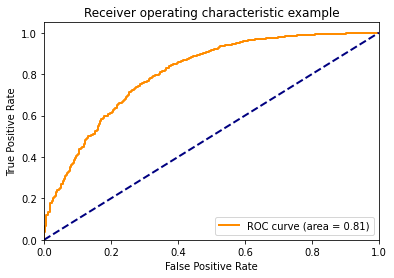

In [ ]:
do_analysis('goodfaith', test_df)

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

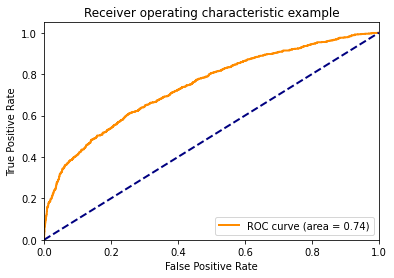

In [ ]:
all_analyses = {}

data = do_analysis('damaging', test_df)
all_analyses['all'] = data

## New editor vs non-new editor analysis

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

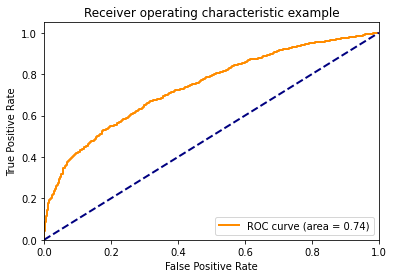

In [ ]:
new_editor_revs = test_df[(test_df['years_since_registration'] < 1) & (test_df['feature.revision.user.is_bot'] == False)]

data = do_analysis('damaging', new_editor_revs)
all_analyses['new_editors'] = data

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

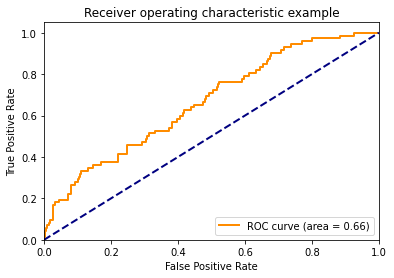

In [ ]:
non_new_editor_revs = test_df[(test_df['years_since_registration'] >= 1) & (test_df['feature.revision.user.is_bot'] == False)]

data = do_analysis('damaging', non_new_editor_revs)
all_analyses['non_new_editors'] = data

## Anonymous editor vs non-anonymous editor analysis

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

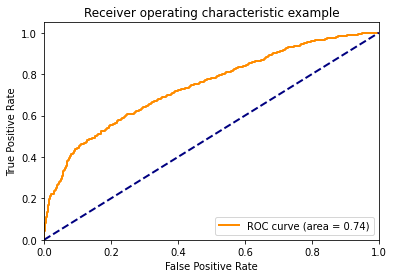

In [ ]:
anon_revs = test_df[(test_df['feature.revision.user.is_anon'] == True) & (test_df['feature.revision.user.is_bot'] == False)]

data = do_analysis('damaging', anon_revs)
all_analyses['anon_editors'] = data

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

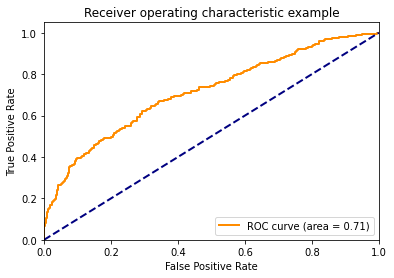

In [ ]:
non_anon_revs = test_df[(test_df['feature.revision.user.is_anon'] == False) & (test_df['feature.revision.user.is_bot'] == False)]

data = do_analysis('damaging', non_anon_revs)
all_analyses['non_anon_editors'] = data

## Mobile editor vs non-mobile editor analyis

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

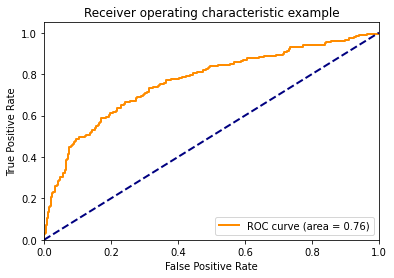

In [ ]:
mobile_revs = test_filtered[test_filtered['tags'].apply(lambda x: 'mobile edit' in x or 'mobile web edit' in x or 'mobile app edit' in x)]

data = do_analysis('damaging', mobile_revs.join(test_df, lsuffix="_x"))
all_analyses['mobile_editors'] = data

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

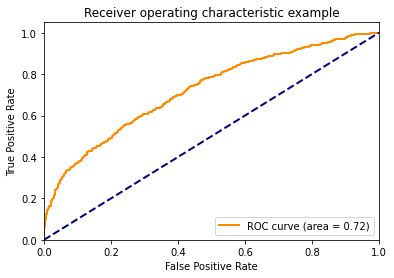

In [ ]:
non_mobile_revs = test_filtered[test_filtered['tags'].apply(lambda x: 'mobile edit' not in x and 'mobile web edit' not in x and 'mobile app edit' not in x)]

data = do_analysis('damaging', non_mobile_revs.join(test_df, lsuffix="_x"))
all_analyses['non_mobile_editors'] = data

## US anon editor vs Non-US anon editor analysis

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

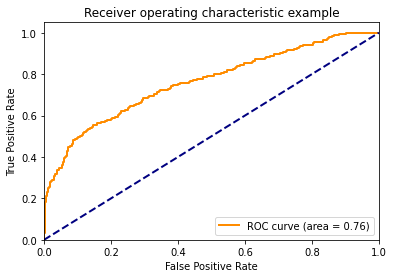

In [ ]:
us_revs = test_filtered[(test_filtered['country'] == "US") & (~test_filtered['country'].isnull())]

data = do_analysis('damaging', us_revs.join(test_df, lsuffix="_x"))
all_analyses['us_anon_editors'] = data

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

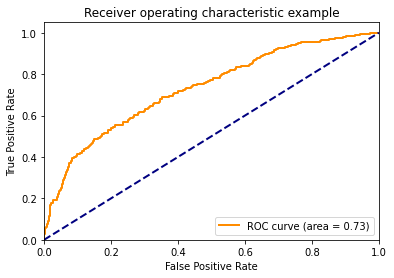

In [ ]:
non_us_revs = test_filtered[(test_filtered['country'] != "US") & (~test_filtered['country'].isnull())]

data = do_analysis('damaging', non_us_revs.join(test_df, lsuffix="_x"))
all_analyses['non_us_anon_editors'] = data

## Intersections: Mobile + anon

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

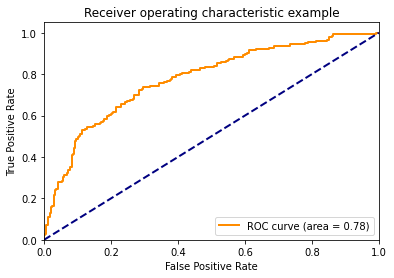

In [ ]:
data = do_analysis('damaging', mobile_revs.join(anon_revs, lsuffix="_x", how='inner'))
all_analyses['mobile_anon_editors'] = data

## Intersections: Mobile + new

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

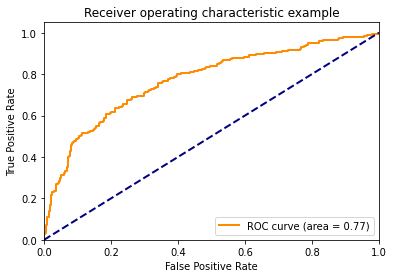

In [ ]:
data = do_analysis('damaging', mobile_revs.join(new_editor_revs, lsuffix="_x", how='inner'))
all_analyses['mobile_new_editors'] = data

## Intersections: Anon + new

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

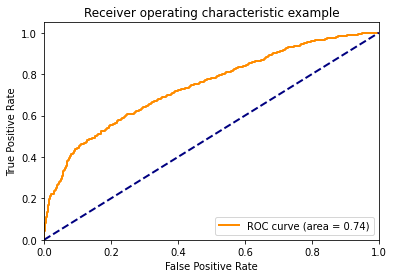

In [ ]:
data = do_analysis('damaging', anon_revs.join(new_editor_revs, lsuffix="_x", how='inner'))
all_analyses['anon_new_editors'] = data

## Intersections: Mobile + anon + new

Differences between the current environment and the environment in which the model was constructed environment were detected:
 - python_compiler 'GCC 6.3.0 20170516' mismatch with original environment 'Clang 11.0.3 (clang-1103.0.32.62)'
 - version '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)' mismatch with original environment 'Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:02 PST 2021; root:xnu-7195.101.1~3/RELEASE_ARM64_T8101'
 - platform 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12' mismatch with original environment 'Darwin-20.4.0-x86_64-i386-64bit'
 - python_version '3.5.3' mismatch with original environment '3.7.7'
 - revscoring_version '2.8.0' mismatch with original environment '2.9.3'
 - python_build ('default', 'Sep 27 2018 17:25:39') mismatch with original environment ('default', 'Jun  2 2020 11:47:11')
 - processor '' mismatch with original environment 'i386'
 - release '4.9.0-11-amd64' mismatch with original environment '20.4.0'
 - system 'Linux' mismatch with original env

model metadata
Model Information:
	 - type: GradientBoosting
	 - version: 0.5.1
	 - params: {'min_weight_fraction_leaf': 0.0, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0, 'min_samples_split': 2, 'tol': 0.0001, 'min_impurity_split': None, 'min_impurity_decrease': 0.0, 'max_depth': 7, 'warm_start': False, 'population_rates': None, 'random_state': None, 'validation_fraction': 0.1, 'subsample': 1.0, 'max_features': 'log2', 'center': True, 'multilabel': False, 'n_estimators': 700, 'label_weights': OrderedDict([(True, 10)]), 'max_leaf_nodes': None, 'verbose': 0, 'scale': True, 'labels': [True, False], 'init': None, 'min_samples_leaf': 1, 'learning_rate': 0.01, 'presort': 'deprecated', 'loss': 'deviance', 'n_iter_no_change': None}
	Environment:
	 - revscoring_version: '2.8.0'
	 - platform: 'Linux-4.9.0-11-amd64-x86_64-with-debian-9.12'
	 - machine: 'x86_64'
	 - version: '#1 SMP Debian 4.9.189-3+deb9u1 (2019-09-20)'
	 - system: 'Linux'
	 - processor: ''
	 - python_build: ('default', 'Sep 27 

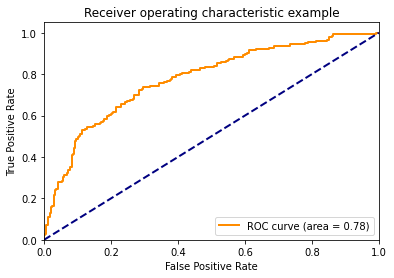

In [ ]:
data = do_analysis('damaging', mobile_revs.join(anon_revs, lsuffix="_x", how='inner').join(new_editor_revs, lsuffix="_y", how='inner'))
all_analyses['mobile_anon_new_editors'] = data

In [ ]:
performance_df = pd.DataFrame.from_dict(all_analyses, orient='index')

In [ ]:
performance_df

accuracy  precision_0  recall_0  f1-score_0  \
all                      0.784543     0.852042  0.878025    0.864838   
new_editors              0.762025     0.841095  0.848372    0.844718   
non_new_editors          0.892749     0.892587  1.000000    0.943245   
anon_editors             0.740937     0.835474  0.811646    0.823388   
non_anon_editors         0.846932     0.870421  0.961769    0.913818   
mobile_editors           0.732372     0.777778  0.811083    0.794081   
non_mobile_editors       0.794657     0.863451  0.888168    0.875635   
us_anon_editors          0.732609     0.851675  0.777293    0.812785   
non_us_anon_editors      0.746647     0.825397  0.835341    0.830339   
mobile_anon_editors      0.721491     0.778182  0.764286    0.771171   
mobile_new_editors       0.728205     0.776000  0.795082    0.785425   
anon_new_editors         0.740937     0.835474  0.811646    0.823388   
mobile_anon_new_editors  0.721491     0.778182  0.764286    0.771171   

                         support_0  precision_1  recall_1  f1-score_1  \
all                           3017     0.498638  0.443099    0.469231   
new_editors                   2427     0.497954  0.484085    0.490921   
non_new_editors                590     1.000000  0.013889    0.027397   
anon_editors                  1683     0.494418  0.535406    0.514096   
non_anon_editors              1334     0.523364  0.226721    0.316384   
mobile_editors                 397     0.642857  0.594714    0.617849   
non_mobile_editors            2620     0.440840  0.385643    0.411398   
us_anon_editors                687     0.477816  0.600858    0.532319   
non_us_anon_editors            996     0.508982  0.491329    0.500000   
mobile_anon_editors            280     0.635359  0.653409    0.644258   
mobile_new_editors             366     0.642857  0.616438    0.629371   
anon_new_editors              1683     0.494418  0.535406    0.514096   
mobile_anon_new_editors        280     0.635359  0.653409    0.644258   

                         support_1  true negatives  true positives  \
all                            826            2649             366   
new_editors                    754            2059             365   
non_new_editors                 72             590               1   
anon_editors                   579            1366             310   
non_anon_editors               247            1283              56   
mobile_editors                 227             322             135   
non_mobile_editors             599            2327             231   
us_anon_editors                233             534             140   
non_us_anon_editors            346             832             170   
mobile_anon_editors            176             214             115   
mobile_new_editors             219             291             135   
anon_new_editors               579            1366             310   
mobile_anon_new_editors        176             214             115   

                         false negatives  false positives  true negative rate  \
all                                  460              368            0.878025   
new_editors                          389              368            0.848372   
non_new_editors                       71                0            1.000000   
anon_editors                         269              317            0.811646   
non_anon_editors                     191               51            0.961769   
mobile_editors                        92               75            0.811083   
non_mobile_editors                   368              293            0.888168   
us_anon_editors                       93              153            0.777293   
non_us_anon_editors                  176              164            0.835341   
mobile_anon_editors                   61               66            0.764286   
mobile_new_editors                    84               75            0.795082   
anon_new_editors                     269

In [ ]:
performance_df.to_csv("damaging_model_performance.csv")

In [1]:
import base64
import nltk
nltk.download('stopwords')

from editquality.feature_lists import enwiki
import json
import mwapi
import numpy as np
import pandas as pd
import pickle
import requests
from revscoring.extractors.api import extractor
from typing import List, Dict, Any
import logging

def get_wikilabels_data(project: str, campaign: int) -> Dict[int, Dict[str, Any]]:
    """Fetches label data directly from the wikilabels domain

    Parameters:
    -----------
    project : str
        A string representing the project to pull from, e.g. "enwiki"
    campaign : int
        An integer representing the id number of a wikilabel campaign

    Returns:
    --------
    dictionary : {rev_id : {attribute : value}}
        A dictionary that maps revisions to most basic labels
    """
    logging.info("getting wikilabels data...")
    resp = requests.get(f"https://labels.wmflabs.org/campaigns/{project}/{campaign}/?tasks")
    data = resp.json()
    labels = {}
    for label in data['tasks']:

        # skip if unlabeled
        if len(label['labels']) == 0:
            continue

        # skip if unsure
        if label['labels'][0]['data']['unsure']:
            continue

        # skip if incomplete labels
        if label['labels'][0]['data']['damaging'] is None or label['labels'][0]['data']['goodfaith'] is None:
            continue

        rev_id = int(label['data']['rev_id'])
        labels[rev_id] = {}
        labels[rev_id]['auto_labeled'] = False
        labels[rev_id]['damaging'] = label['labels'][0]['data']['damaging']
        labels[rev_id]['goodfaith'] = label['labels'][0]['data']['goodfaith']
        labels[rev_id]['autolabel'] = {}
    return labels

def fetch_revscoring_data(processed_dict: Dict[int, Dict[str, Any]], subdomain: str, label: str) -> Dict[int, Dict[str, Any]]:
    """Uses the revscoring extractor API to get all relevant data for a given dataset.

    Parameters:
    -----------
    processed_dict : {rev_id : {attribute : value}}
        Dictionary that maps revision ids to labels and features
    subdomain : str
        The subdomain to get revision data from
    label : str
        The label (either "goodfaith" or "damaging") to pull data for

    Returns:
    --------
    dictionary : {rev_id : {attribute : value}}
        Dictionary that maps revision ids to labels and features

    Raises:
    -------
    ValueError
        If label to pull data for is invalid
    """
    logging.info("fetching revscoring data...")
    session = mwapi.Session(f"https://{subdomain}.org")
    e = extractor.Extractor(session)

    
    try:
        if label == "goodfaith":
            dependent = enwiki.goodfaith
        elif label == "damaging":
            dependent = enwiki.damaging
    except ValueError:
        return "Invalid label"

    for rev_id, rev in zip(processed_dict.keys(), e.extract(processed_dict.keys(), dependent)):
        for feature, value in zip(dependent, rev):
            processed_dict[rev_id][feature] = value

    return processed_dict

def get_decoded_labeled_revisions(path: str, labels: List[str]) -> Dict[int, Dict[str, Any]]:
    """Takes in an base-85 encoded json file of revisions (returned as an output of
    `revscoring extract...` shell command) and returns plaintext data dictionary.

    Parameters:
    -----------
    path : str
        Path to the encoded json file
    labels : [str]
        List of labels to extract, e.g. ['damaging', 'goodfaith']
    
    Returns:
    --------
    dictionary : {rev_id : {attribute : value}}
        Dictionary that maps rev_ids to rows represented by attribute value pairs
    """
    logging.info("decoding labeled revisions...")
    processed_dict = {}

    with open(path) as f:
        for line in f:
            observation = json.loads(line)
            if 'cache' in observation:
                observation['cache'] = pickle.loads(
                    base64.b85decode(bytes(observation['cache'], 'ascii')))
            else:
                continue

            processed_dict[observation['rev_id']] = {label: observation[label] for label in labels}
            processed_dict[observation['rev_id']].update(observation['cache'])
            
    return processed_dict

def get_revision_metadata(processed_dict: Dict[int, Dict[str, Any]], subdomain: str) -> Dict[int, Dict[str, Any]]:
    """Takes in the decoded set of revisions returned by `get_decoded_revisions` and a
    language and returns the same dictionary with relevant metadata, like page title,
    username, timestamp, comment, etc.

    Parameters:
    -----------
    processed_dict : {rev_id : {attribute : value}}
        A dictionary of revisions output by `get_decoded_revisions`
    subdomain : str
        A mediawiki project in the form of <language>.<project>, e.g. en.wikipedia

    Returns:
    --------
    dictionary : {rev_id : {attribute : value}}
        Dictionary that maps rev_ids to rows represented by attribute value pairs with
        extra metadata attached 
    """
    logging.info("getting revision metadata...")
    session = mwapi.Session(f'https://{subdomain}.org')

    for rev_id in processed_dict.keys():

        s = session.get(action='query', prop='revisions', revids=rev_id, rvprop='ids|timestamp|flags|comment|user|tags')
        for rev in s['query']['pages'].values():
            processed_dict[rev_id]['title'] = rev['title']
            processed_dict[rev_id]['user'] = rev['revisions'][0]['user']
            processed_dict[rev_id]['timestamp'] = rev['revisions'][0]['timestamp']
            processed_dict[rev_id]['comment'] = rev['revisions'][0]['comment']

            processed_dict[rev_id]['tags'] = rev['revisions'][0]['tags']

    return processed_dict

def labeled_revisions_to_df(processed_dict: Dict[int, Dict[str, Any]]) -> pd.DataFrame:
    """Finishes revision preprocessing and returns an easy-to-work-with pandas dataframe

    Parameters:
    -----------
    processed_dict : {rev_id : {attribute : value}}
        A dictionary of rows mapping revisions to sets of column values

    Returns:
    --------
    pd.DataFrame :
        A filtered dataframe representation of the dataset, with other relevant metadata attached
    """
    logging.info("converting labeled revisions to dataframe...")
    df = pd.DataFrame.from_dict(processed_dict, orient='index') 
    df['seconds_since_registration'] = np.exp(df['feature.log((temporal.revision.user.seconds_since_registration + 1))']) - 1
    df['days_since_registration'] = df['seconds_since_registration'] / 86400
    df['years_since_registration'] = df['days_since_registration'] / 365

    keep = ['damaging', 'goodfaith', '<feature.revision.page.is_articleish>',
            '<feature.revision.page.is_mainspace>', '<feature.revision.page.is_draftspace>',
            'feature.revision.diff.chars_change', 'feature.revision.diff.tokens_change',
            'feature.revision.diff.words_change', 'seconds_since_registration',
            'days_since_registration', 'years_since_registration',
            'feature.english.badwords.revision.diff.match_delta_sum',
            'feature.english.informals.revision.diff.match_delta_sum',
            'feature.english.dictionary.revision.diff.dict_word_delta_sum',
            'feature.english.dictionary.revision.diff.non_dict_word_delta_sum',
            'user', 'feature.revision.user.is_bot', 'feature.revision.user.has_advanced_rights',
            'feature.revision.user.is_anon', 'country', 'tags', 'timestamp']

    filtered = df[keep]
    filtered.timestamp = pd.to_datetime(filtered.timestamp)

def main():
    logging.basicConfig(filename='extract-data.log', level=logging.DEBUG)
    project = "enwiki"
    subdomain = "en.wikipedia"
    label = "goodfaith"
    campaign = 41

    processed_dict = get_wikilabels_data(project=project, campaign=campaign)
    processed_dict = fetch_revscoring_data(processed_dict=processed_dict, subdomain=subdomain, label=label)
    processed_dict = get_revision_metadata(processed_dict=processed_dict, subdomain=subdomain)
    df = labeled_revisions_to_df(processed_dict=processed_dict)
    print(df.head)

ModuleNotFoundError: No module named 'nltk'